# Introduction to some forms of parallelism

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [142]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool

### Sleep exemple

In [144]:
%%time
T = [5, 10, 15, 20]
for t in T:
    time.sleep(t)

CPU times: user 2.73 ms, sys: 26 µs, total: 2.75 ms
Wall time: 50 s


In [145]:
%%time
with ThreadPoolExecutor(max_workers=len(T)) as executor:
    executor.map(time.sleep, T)

CPU times: user 1 ms, sys: 3.95 ms, total: 4.95 ms
Wall time: 20 s


In [147]:
%%time
with Pool(len(T)) as pool:
    pool.map(time.sleep, T)

CPU times: user 8.98 ms, sys: 32.1 ms, total: 41.1 ms
Wall time: 20.1 s


In [148]:
def check_prime(x):
    is_prime = True
    for a in range(2, x):
        if x%a == 0: 
            is_prime = False
            break
    return is_prime

def n_primes(sl):
    return sum(map(check_prime, range(sl[0], sl[1]+1)))

In [149]:
%%time
x = 100000
n_primes([1, x])

CPU times: user 15.4 s, sys: 0 ns, total: 15.4 s
Wall time: 15.4 s


9593

In [158]:
n_workers = 5
per_thread = x//n_workers
slices = [[i*per_thread + 1, (i+1)*per_thread] for i in range(n_workers)]

In [151]:
%%time
with ThreadPoolExecutor(max_workers=n_workers) as executor:
    output = executor.map(n_primes, slices)
sum(output)

CPU times: user 27.4 s, sys: 181 ms, total: 27.6 s
Wall time: 27.3 s


9593

In [152]:
%%time
with Pool(n_workers) as pool:
    output = pool.map(n_primes, slices)
sum(output)

CPU times: user 5.45 ms, sys: 60.3 ms, total: 65.7 ms
Wall time: 5.86 s


9593

### $\pi$ estimation exemple

Given a circle region $C$ of radius $R$, centred on origin, and arbitrary values $x, y \in [0, R]$,
$$
R^2 p((x, y) \in C) = \frac{\pi R^2}{4} \longrightarrow \pi = 4p((x, y) \in C),
$$
cosiderating
$$
p((x, y) \in C) = \lim_{N \to \infty} \frac{\sum_{i}^N g(\sqrt{x_i^2 + y_i^2})}{N},
$$
where
$$
g(r) = \left\{
    \begin{array}{rl}
        1, & r \le 1\\
        0, & r > 1
    \end{array}
\right..
$$

In [159]:
from random import random

def g(n):
        return sum([int(np.sqrt(random()**2 + random()**2) <= 1) for _ in range(n)])

In [160]:
N = 10000000
4*g(N)/N

3.1419552

In [155]:
n_workers = 5
Ns = [N//n_workers]*n_workers

In [156]:
%%time
with ThreadPoolExecutor(max_workers=n_workers) as executor:
    output = executor.map(g, Ns)
4*sum(output)/N

CPU times: user 20.7 s, sys: 233 ms, total: 20.9 s
Wall time: 20.7 s


3.1420264

In [157]:
%%time
with Pool(n_threads) as pool:
    output = pool.map(g, Ns)
4*sum(output)/N

CPU times: user 9.08 ms, sys: 44.2 ms, total: 53.2 ms
Wall time: 3.8 s


3.140642

In [117]:
%%time
Ns = np.linspace(1, 1e7, 10).astype(int)
workers = np.arange(1, 11)
eltime = np.stack([timeit(get_pi, N)[0] for N in Ns])
eltime_parallel = np.stack([[timeit(get_pi_parallel, N, n_blocks)[0] for N in Ns] for n_blocks in workers])

CPU times: user 1min 1s, sys: 5.12 s, total: 1min 6s
Wall time: 5min 11s


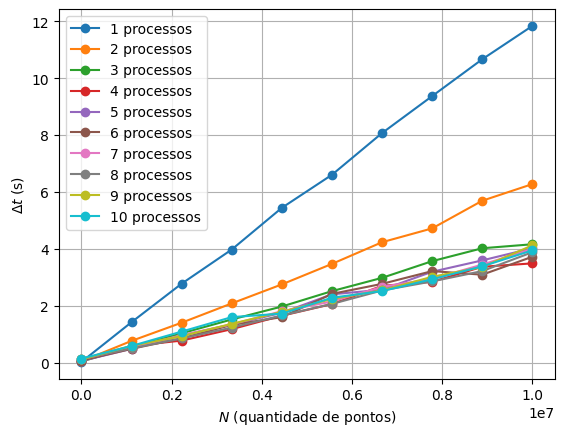

In [179]:
# plt.plot(Ns, eltime, '-o', label='Linear')
for i, t in zip(workers, eltime_parallel): plt.plot(Ns, t, '-o', label=f'{i} processos')
plt.xlabel('$N$ (quantidade de pontos)')
plt.ylabel('$\Delta t$ (s)')
plt.grid()
plt.legend()
plt.show()

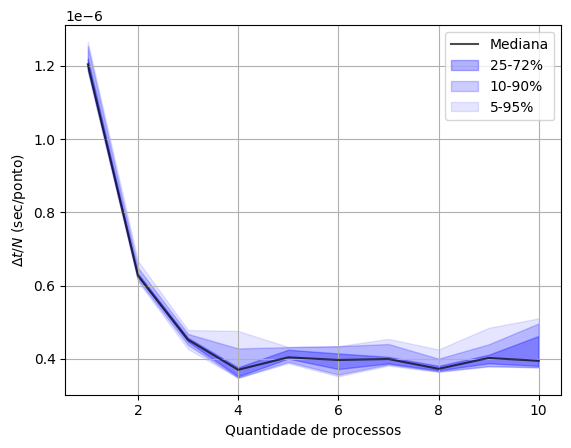

In [180]:
y = eltime_parallel.T[1:]/Ns[1:][..., np.newaxis]
plt.plot(workers, np.median(y, axis=0), 'k-', alpha=0.7, label='Mediana')
for pi, pf, a in ((25, 72, 0.3), (10, 90, 0.2), (5, 95, 0.1)):
    plt.fill_between(workers, np.percentile(y, pi, axis=0), np.percentile(y, pf, axis=0), color='blue', alpha=a, label=f'{pi}-{pf}%')
plt.legend()
plt.xlabel('Quantidade de processos')
plt.ylabel('$\Delta t / N$ (sec/ponto)')
plt.grid()
plt.show()

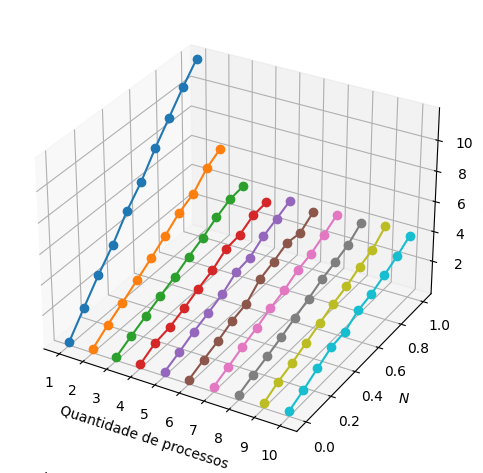

In [181]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.tight_layout()
for i, t in zip(workers, eltime_parallel): ax.plot(np.full(Ns.shape, i), Ns, t, '-o')
plt.xlabel('Quantidade de processos')
plt.xticks(workers)
plt.ylabel('$N$')
ax.set_zlabel('$\Delta t$ (s)')
plt.grid()
# plt.legend()
plt.show()